In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
from time import time

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
import targeting
import casjobs

import numpy as np

from scipy import interpolate

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import table
from astropy.table import Table
from astropy.io import fits

from astropy.utils.console import ProgressBar
from astropy.utils import data

from collections import Counter

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

In [5]:
from IPython import display

In [40]:
def make_cutout_comparison_table(dcat):
    """
    Produces a table comparing DECaLS and SDSS objects side-by-side
    
    `dcat` should be a *DECaLS* catalog, not SDSS
    """
    de_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra={0.ra.deg}&dec={0.dec.deg}&layer=decals-dr3&pixscale=0.1&bands=grz'
    sd_cutout_url = 'http://legacysurvey.org/viewer/jpeg-cutout/?ra={0.ra.deg}&dec={0.dec.deg}&layer=sdssco&pixscale=0.1&bands=gri'

    print('put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx')
    print('name ra dec')

    tabrows = []
    for row in dcat:
        dviewurl = 'http://legacysurvey.org/viewer?ra={}&dec={}'.format(row['ra'], row['dec'])
        sviewurl = 'http://skyserver.sdss.org/dr12/en/tools/chart/navi.aspx?ra={}&dec={}'.format(row['ra'], row['dec'])
        sc = SkyCoord(row['ra'], row['dec'], unit=u.deg)
        objstr = '{}_{}<br>RA={:.4f}<br>Dec={:.4f}<br>r={:.2f}<br>sb={:.2f}'.format(row['brickid'], row['objid'], row['ra'], row['dec'], row['r'], row['sb_r_0.5'])
        deimg = '<a href="{}"><img src="{}"></a>'.format(dviewurl, de_cutout_url.format(sc))
        sdimg = '<a href="{}"><img src="{}"></a>'.format(sviewurl, sd_cutout_url.format(sc))
        tabrows.append('<tr><td>{}</td><td>{}</td><td>{}</td></tr>'.format(objstr, deimg, sdimg))
        print(row['brickname']+'_'+str(row['objid']), row['ra'], row['dec'])

    htmlstr = """
    <table>

    <tr>
    <th>obj</th>
    <th>DECALS</th>
    <th>SDSS</th>
    </tr>

    {}
    </table>
    """.format('\n'.join(tabrows))
    
    return display.HTML(htmlstr)

In [6]:
# from the DECALS low-SB_brick selection and data download notebook
bricknames = ['1181m012', '2208m005']

For more in-depth on the context for these, see ``DECALS low-SB_catalog completeness.ipynb``

# Load the catalogs 

In [7]:
catalog_fns = ['decals_dr3/catalogs/tractor-{}.fits'.format(bnm) for bnm in bricknames]
decals_catalogs = [Table.read(fn) for fn in catalog_fns]

In [8]:
sdss_fns = ['decals_dr3/catalogs/sdss_comparison_{}.csv'.format(bnm) for bnm in bricknames]
sdss_catalogs = [Table.read(fn) for fn in sdss_fns]

In [9]:
bricks = Table.read('decals_dr3/survey-bricks.fits.gz')
bricksdr3 = Table.read('decals_dr3/survey-bricks-dr3.fits.gz')

## Populate additional  info in the DECaLS tables

In [10]:
ap_sizes = [0.5,0.75,1.0,1.5,2.0,3.5,5.0,7.0] * u.arcsec 

In [11]:
def compute_sb(rad, apflux):
    if len(apflux.shape)==2:
        idxs = np.where(ap_sizes==rad)[0]
        assert len(idxs)==1, 'No aperture with size {}'.format(rad)
        
        apflux = apflux[:, idxs[0]]
    A = 2.5*np.log10(np.pi*(rad.to(u.arcsec).value)**2)
    return np.array(22.5 - 2.5*np.log10(apflux) + A) * u.mag * u.arcsec**-2
        
for dcat in decals_catalogs:
    dcat['g'] = np.array(22.5 - 2.5*np.log10(dcat['decam_flux'][:, 1]))*u.mag
    dcat['r'] = np.array(22.5 - 2.5*np.log10(dcat['decam_flux'][:, 2]))*u.mag
    dcat['z'] = np.array(22.5 - 2.5*np.log10(dcat['decam_flux'][:, 4]))*u.mag
    
    dcat['sb_r_0.5'] = compute_sb(0.5*u.arcsec, dcat['decam_apflux'][:, 2, :])
    dcat['sb_r_0.75'] = compute_sb(0.75*u.arcsec, dcat['decam_apflux'][:, 2, :])
    dcat['sb_r_1'] = compute_sb(1.0*u.arcsec, dcat['decam_apflux'][:, 2, :])
    dcat['sb_r_2'] =compute_sb(2.0*u.arcsec, dcat['decam_apflux'][:, 2, :])

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/sag

# Compute SDSS-like SB's

We want to try to get a surface birghtness something like SDSS's expmag + 2.5 log10(2 pi exprad^2).  But DECaLS has no expmag.  So lets try interpolating the aperture fluxes to the appropriate radius.

In [12]:
dcat0 = decals_catalogs[0]
rap_fluxes = dcat0['decam_apflux'][:, 2, :]

expfluxr = np.empty_like(rap_fluxes[:, 0])
ap_sizesv = ap_sizes.to(u.arcsec).value
for i in ProgressBar(range(len(rap_fluxes)), ipython_widget=True):
    f = rap_fluxes[i]
    r = dcat0['shapeExp_r'][i]
    expfluxr[i] = np.interp(r, ap_sizesv, f)

Now lets visualize a few of these flux profiles just to see if this seems sensible

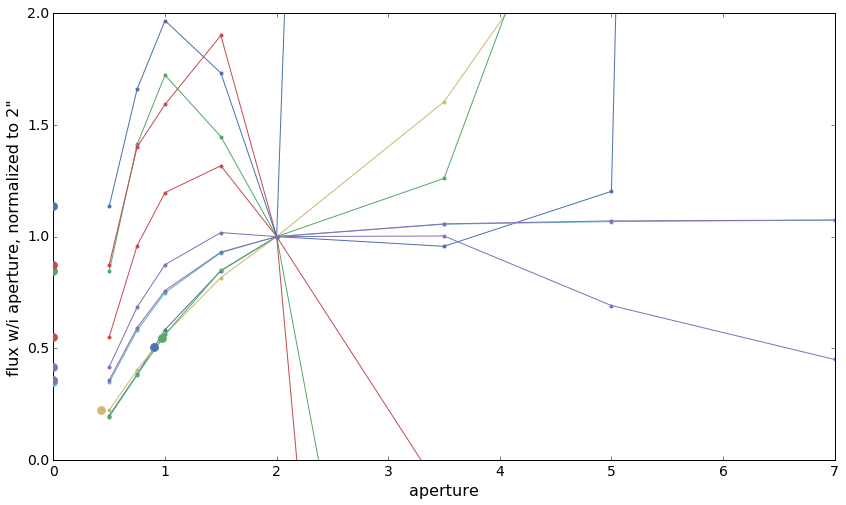

In [13]:
j = 0
for i in np.random.permutation(len(rap_fluxes)):
    fnorm = rap_fluxes[i][4]
    p = plt.plot(ap_sizes, rap_fluxes[i]/fnorm,'-o', ms=4, mew=0)[0]
    plt.scatter([dcat0['shapeExp_r'][i]], [expfluxr[i]/fnorm], color=p.get_color(), s=60, zorder=5)
    j += 1
    if j>9:
        break

plt.xlim(0, 7)
plt.ylim(0, 2)
plt.xlabel('aperture')
plt.ylabel('flux w/i aperture, normalized to 2"')

What's the deal with all those objects that have an shapeExp_r of 0?

In [14]:
Counter(dcat0[dcat0['shapeExp_r']>0]['type']), Counter(dcat0[dcat0['shapeExp_r']==0]['type'])

(Counter({'COMP': 34, 'EXP ': 1113, 'SIMP': 696}),
 Counter({'DEV ': 243, 'PSF ': 6437}))

Oops... looks like stars, and more importantly, DeV-fit galaxies, have no shapeExp_r!  Guess we have to use other shapes for them.  So we'll use `decam_psfsize` for the stars, `shapeDev_r` for the early-types, and `shapeExp_r` for other gals.

In [15]:
dcat0 = decals_catalogs[0]
rap_fluxes = dcat0['decam_apflux'][:, 2, :]

fluxr = np.empty_like(rap_fluxes[:, 0])
rap_sizesv = ap_sizes.to(u.arcsec).value

intr = interpolate.BarycentricInterpolator(ap_sizesv, [0]*len(ap_sizesv))
for i in ProgressBar(range(len(rap_fluxes)), ipython_widget=True):
    f = rap_fluxes[i]
    if dcat0['type'][i] == 'PSF ':
        r = dcat0['decam_psfsize'][i, 2]
    elif dcat0['type'][i] == 'DEV ':
        r = dcat0['shapeDev_r'][i]
    else:
        r = dcat0['shapeExp_r'][i]
        
    intr.set_yi(f)
    fluxr[i] = intr(r)

triangles are DeV, circles are exp, * are PSFs


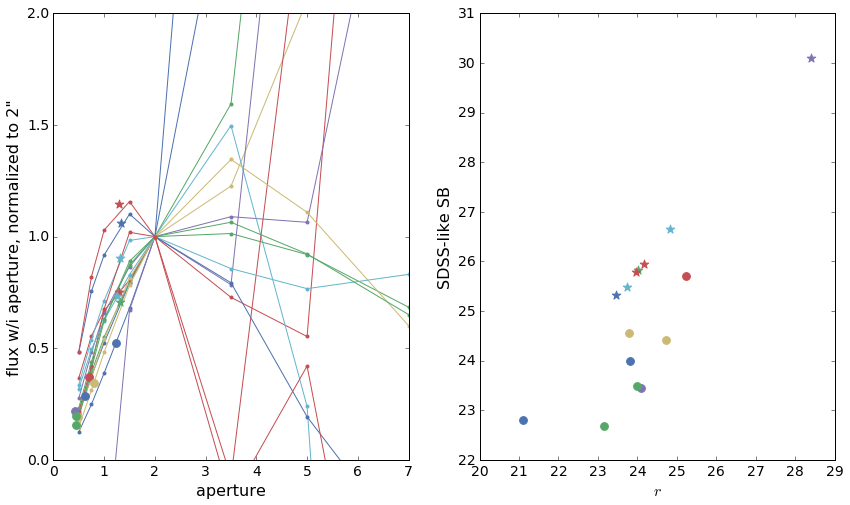

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)

rs = []
fluxes = []
colors = []
markers = []
for i in np.random.permutation(len(rap_fluxes))[:15]:
    fnorm = rap_fluxes[i][4]
    p = ax1.plot(ap_sizes, rap_fluxes[i]/fnorm,'-o', ms=4, mew=0)[0]
    colors.append(p.get_color())
    if dcat0['type'][i] == 'PSF ':
        rs.append(dcat0['decam_psfsize'][i, 2])
        markers.append('*')
    elif dcat0['type'][i] == 'DEV ':
        rs.append(dcat0['shapeDev_r'][i])
        markers.append('^')
    else:
        rs.append(dcat0['shapeExp_r'][i])
        markers.append('o')
    fluxes.append(fluxr[i])
    
    ax1.scatter([rs[-1]], [fluxr[i]/fnorm], color=colors[-1], 
                s=60 if markers[-1]=='o' else 80,
                zorder=5, marker=markers[-1])
    
#     #uncomment this to look at the total flux of a star
#     if markers[-1]=='*':
#         ax1.scatter([rs[-1]], [dcat0['decam_flux'][i, 2]/fnorm], color=colors[-1], 
#                     s=60 if markers[-1]=='o' else 80,
#                     zorder=5, marker='s')
        
ax1.set_xlim(0, 7)
ax1.set_ylim(0, 2)
ax1.set_xlabel('aperture')
ax1.set_ylabel('flux w/i aperture, normalized to 2"')

sb = compute_sb(rs*u.arcsec, np.array(fluxes))
mags = np.array(22.5 - 2.5*np.log10(fluxes))
for x, y, c, m in zip(mags, sb, colors, markers):
    ax2.scatter([x], [y.value], color=c, 
                s=60 if m=='o' else 80,
                zorder=5, marker=m)
ax2.set_xlabel('$r$')
ax2.set_ylabel('SDSS-like SB')
    
print('triangles are DeV, circles are exp, * are PSFs')

In [17]:
for dcat in decals_catalogs:
    rap_fluxes = dcat['decam_apflux'][:, 2, :]

    expflux_r = np.empty_like(rap_fluxes[:, 0])
    rad = np.empty(len(rap_fluxes[:, 0]))
    ap_sizesv = ap_sizes.to(u.arcsec).value

    intr = interpolate.BarycentricInterpolator(ap_sizesv, [0]*len(ap_sizesv))
    for i in ProgressBar(range(len(rap_fluxes)), ipython_widget=True):
        f = rap_fluxes[i]
        if dcat['type'][i] == 'PSF ':
            r = dcat['decam_psfsize'][i, 2]
        elif dcat['type'][i] == 'DEV ':
            r = dcat['shapeDev_r'][i]
        else:
            r = dcat['shapeExp_r'][i]

        intr.set_yi(f)
        expflux_r[i] = intr(r)
        rad[i] = r
        
    dcat['sdss_like_sb_r'] = compute_sb(rad*u.arcsec, np.array(expflux_r))

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in add


# Cut out areas of overlap from the bricks, and then combine them

In [18]:
boundaries = [((-1.375, -1.2), (118, 118.145)),
              ((-0.625, -0.375), (220.75, 221))]

In [19]:
dcut = []
scut = []

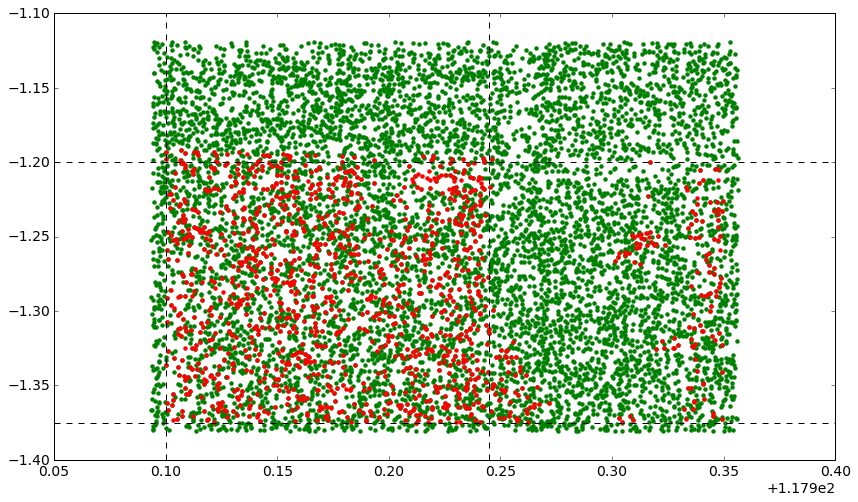

In [20]:
dcat = decals_catalogs[0]
scat = sdss_catalogs[0]
bnds = boundaries[0]

plt.scatter(dcat['ra'], dcat['dec'], lw=0, c='g')
plt.scatter(scat['RA'], scat['DEC'], lw=0, c='r')

plt.axhline(bnds[0][0], c='k', ls='--')
plt.axhline(bnds[0][1], c='k', ls='--')
plt.axvline(bnds[1][0], c='k', ls='--')
plt.axvline(bnds[1][1], c='k', ls='--')

dmsk = ((bnds[1][0]<dcat['ra']) & (dcat['ra']<bnds[1][1]) &
        (bnds[0][0]<dcat['dec']) & (dcat['dec']<bnds[0][1]))
dcut.append(dcat[dmsk])


smsk = ((bnds[1][0]<scat['RA']) & (scat['RA']<bnds[1][1]) &
        (bnds[0][0]<scat['DEC']) & (scat['DEC']<bnds[0][1]))
scut.append(scat[smsk])

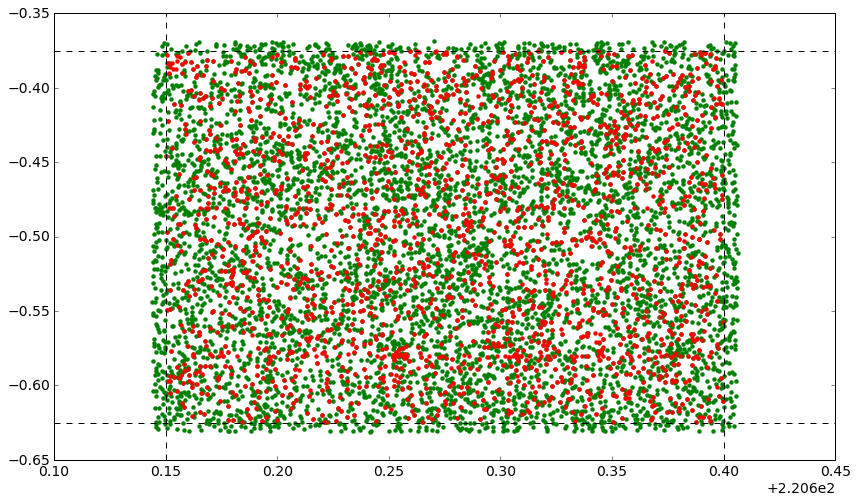

In [21]:
dcat = decals_catalogs[1]
scat = sdss_catalogs[1]
bnds = boundaries[1]

plt.scatter(dcat['ra'], dcat['dec'], lw=0, c='g')
plt.scatter(scat['RA'], scat['DEC'], lw=0, c='r')

plt.axhline(bnds[0][0], c='k', ls='--')
plt.axhline(bnds[0][1], c='k', ls='--')
plt.axvline(bnds[1][0], c='k', ls='--')
plt.axvline(bnds[1][1], c='k', ls='--')

dmsk = ((bnds[1][0]<dcat['ra']) & (dcat['ra']<bnds[1][1]) &
        (bnds[0][0]<dcat['dec']) & (dcat['dec']<bnds[0][1]))
dcut.append(dcat[dmsk])


smsk = ((bnds[1][0]<scat['RA']) & (scat['RA']<bnds[1][1]) &
        (bnds[0][0]<scat['DEC']) & (scat['DEC']<bnds[0][1]))
scut.append(scat[smsk])

In [22]:
dcutall = table.vstack(dcut)
scutall = table.vstack(scut)

# X-matching catalogs

In [23]:
dsc = SkyCoord(dcutall['ra'], dcutall['dec'], unit=u.deg)
ssc = SkyCoord(scutall['RA'], scutall['DEC'], unit=u.deg)

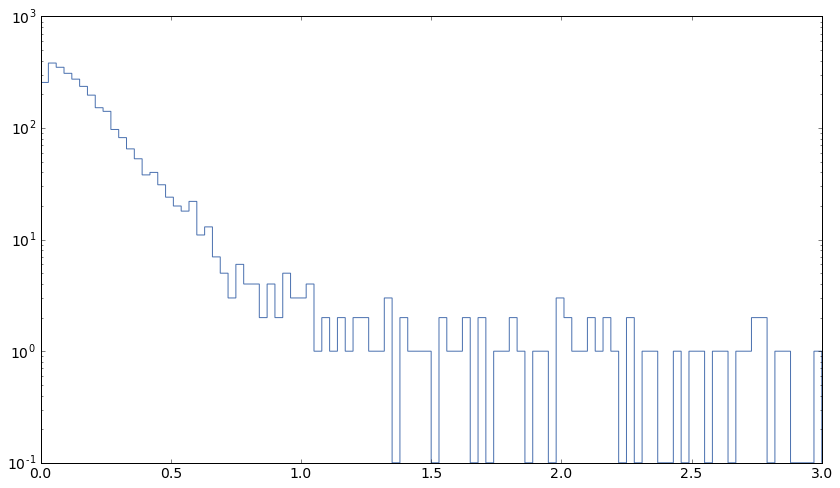

In [24]:
idx, d2d, _ = ssc.match_to_catalog_sky(dsc)
plt.hist(d2d.arcsec, bins=100, range=(0, 3),histtype='step', log=True)
None

In [25]:
dmatchmsk = idx[d2d<1.5*u.arcsec]
dmatch = dcutall[dmatchmsk]

smatch = scutall[d2d<1.5*u.arcsec]

In [26]:
didxs = np.arange(len(dcutall))
dnomatchmsk = didxs[~np.in1d(didxs, idx[d2d<1.5*u.arcsec])]
dnomatch = dcutall[dnomatchmsk]

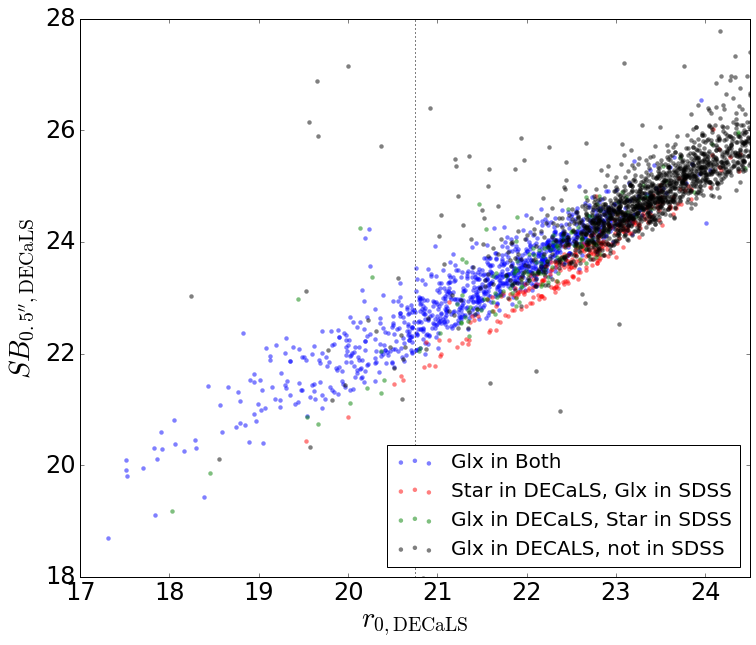

In [27]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sb_r_0.5'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
sstar = smatch['PHOT_SG']=='STAR'
plt.scatter(x[~dstar&~sstar], y[~dstar&~sstar], c='b', lw=0, alpha=.5, label='Glx in Both')
plt.scatter(x[dstar&~sstar], y[dstar&~sstar], c='r', lw=0, alpha=.5, label='Star in DECaLS, Glx in SDSS')
plt.scatter(x[~dstar&sstar], y[~dstar&sstar], c='g', lw=0, alpha=.5, label='Glx in DECaLS, Star in SDSS')

dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar], (dnomatch[ynm] - dnoext)[~dnstar], 
            c='k', lw=0, alpha=.5, label='Glx in DECALS, not in SDSS')

#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 28)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{0.5^{\prime \prime}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)
plt.savefig(os.environ['HOME'] + '/Desktop/fig_decals.pdf')

### Galaxies in DECaLS w/ low SB

In [41]:
to_check = (dcutall['r']<21)&(dcutall['sb_r_0.5']>24.5) & (dcutall['type']!='PSF ')
make_cutout_comparison_table(dcutall[to_check])

put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx
name ra dec
1181m012_678 118.112199737 -1.36244765285
1181m012_993 118.073844294 -1.35064712055
1181m012_2942 118.093188198 -1.29399519212
1181m012_2945 118.087942554 -1.2876046284
2208m005_785 220.792331062 -0.597459136591


/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


obj,DECALS,SDSS
323640_678RA=118.1122Dec=-1.3624r=20.08sb=27.24,,
323640_993RA=118.0738Dec=-1.3506r=19.64sb=26.22,,
323640_2942RA=118.0932Dec=-1.2940r=19.75sb=25.98,,
323640_2945RA=118.0879Dec=-1.2876r=19.74sb=26.97,,
328371_785RA=220.7923Dec=-0.5975r=20.45sb=25.81,,


All seem to be artifacts in DECaLS - scattered light, cosmic rays, etc

### Galaxies in DECaLS, *nothing* in SDSS

In [42]:
to_check = ((18<dnomatch['r']) & (dnomatch['r']<21) &
            (18<dnomatch['sb_r_0.5']) & (dnomatch['sb_r_0.5']<24.5) & 
            (dnomatch['type']!='PSF '))
make_cutout_comparison_table(dnomatch[to_check])


put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx
name ra dec
1181m012_961 118.121513445 -1.35257640112
1181m012_1384 118.038073493 -1.34092907625
1181m012_1656 118.090730955 -1.33314864522
1181m012_1800 118.117388763 -1.32869772927
1181m012_2014 118.083627175 -1.32579902208
1181m012_2700 118.112946373 -1.29868529355
1181m012_2876 118.031814095 -1.29029361373
1181m012_2878 118.030590431 -1.29002895308
1181m012_2880 118.028672101 -1.28997846323
1181m012_2912 118.003665054 -1.29901194917
1181m012_2935 118.087672265 -1.29341850195
1181m012_3798 118.088913439 -1.26723945505
1181m012_4682 118.087427046 -1.23734510488
1181m012_4685 118.088564737 -1.24490918031
1181m012_5813 118.090766692 -1.20919653906
2208m005_968 220.855751224 -0.592980315504
2208m005_2626 220.816086592 -0.533070890865
2208m005_4659 220.897160891 -0.458573580142
2208m005_6437 220.812481307 -0.398810751892
2208m005_6656 220.750771946 -0.386014017194


/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


obj,DECALS,SDSS
323640_961RA=118.1215Dec=-1.3526r=20.60sb=21.82,,
323640_1384RA=118.0381Dec=-1.3409r=20.64sb=20.31,,
323640_1656RA=118.0907Dec=-1.3331r=19.85sb=22.16,,
323640_1800RA=118.1174Dec=-1.3287r=19.66sb=20.41,,
323640_2014RA=118.0836Dec=-1.3258r=20.05sb=21.52,,
323640_2700RA=118.1129Dec=-1.2987r=20.40sb=22.49,,
323640_2876RA=118.0318Dec=-1.2903r=20.68sb=22.43,,
323640_2878RA=118.0306Dec=-1.2900r=20.69sb=21.28,,
323640_2880RA=118.0287Dec=-1.2900r=20.70sb=21.98,,
323640_2912RA=118.0037Dec=-1.2990r=20.64sb=23.44,,


These are almost entirely either deblender ambiguities (i.e. by eye may or may not be two sources) or areas where SDSS had a scattered-light/background problem.  A few debatebly real objects, but not preferentially low-SB or anything.

### Gals in DECaLS, stars in SDSS 

In [46]:
to_check = ~dstar&sstar&(dmatch['r']<21)
make_cutout_comparison_table(dmatch[to_check])


put this into http://skyserver.sdss.org/dr13/en/tools/chart/listinfo.aspx
name ra dec
1181m012_4370 118.00903537 -1.25056657662
1181m012_5940 118.00881619 -1.20212316278
1181m012_5564 118.057734628 -1.21970565011
1181m012_49 118.122769028 -1.37418441193
1181m012_5499 118.001479221 -1.2214788251
1181m012_408 118.023907004 -1.36462119026
1181m012_994 118.075494053 -1.35493962314
1181m012_5371 118.122140921 -1.21010441942
1181m012_5341 118.121170142 -1.21261239748
1181m012_1509 118.050831575 -1.32103677862
1181m012_991 118.076940742 -1.3517534848
1181m012_4088 118.140225545 -1.25900783411
1181m012_3108 118.06608604 -1.29011770684
1181m012_2358 118.136238488 -1.31197729034
1181m012_2052 118.067539464 -1.32199988816
1181m012_2932 118.09147149 -1.29033801472
2208m005_2546 220.923439054 -0.531831133477
2208m005_1496 220.946007697 -0.568820576871
2208m005_1958 220.951999097 -0.561450444598
2208m005_1493 220.938821057 -0.564776676641
2208m005_1491 220.944180245 -0.57134820099
2208m005_4522 220.

obj,DECALS,SDSS
323640_4370RA=118.0090Dec=-1.2506r=18.54sb=19.94,,
323640_5940RA=118.0088Dec=-1.2021r=20.12sb=21.21,,
323640_5564RA=118.0577Dec=-1.2197r=20.37sb=23.47,,
323640_49RA=118.1228Dec=-1.3742r=12.09sb=17.74,,
323640_5499RA=118.0015Dec=-1.2215r=20.89sb=22.14,,
323640_408RA=118.0239Dec=-1.3646r=20.48sb=21.60,,
323640_994RA=118.0755Dec=-1.3549r=20.22sb=24.34,,
323640_5371RA=118.1221Dec=-1.2101r=19.65sb=20.98,,
323640_5341RA=118.1212Dec=-1.2126r=9.92sb=17.07,,
323640_1509RA=118.0508Dec=-1.3210r=12.14sb=17.51,,


A few are *possibly* real due to improved seeing (323640_5940, 323640_5564), vast majority are either areas where SDSS backgrounds are problematic, or bright star artifacts/blended stars.

# Try with other aperture sizes

This also has a few more points for stars just to see the differences.  That's why we still include 0.5 even though it's above, too

## 0.5" 

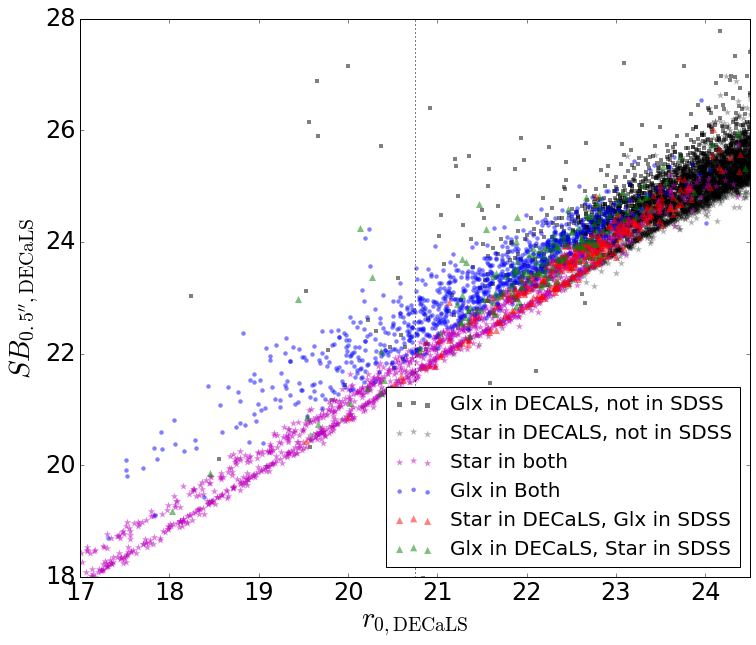

In [30]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sb_r_0.5'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
sstar = smatch['PHOT_SG']=='STAR'


dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar], (dnomatch[ynm] - dnoext)[~dnstar], 
            c='k', lw=0, alpha=.5, label='Glx in DECALS, not in SDSS', marker='s')
plt.scatter((dnomatch[xnm] - dnoext)[dnstar], (dnomatch[ynm] - dnoext)[dnstar], 
            c='k', lw=0, alpha=.3, s=60, 
            label='Star in DECALS, not in SDSS', marker='*')

plt.scatter(x[dstar&sstar], y[dstar&sstar], c='m', lw=0, alpha=.5, s=60,
            label='Star in both', marker='*')

plt.scatter(x[~dstar&~sstar], y[~dstar&~sstar], c='b', lw=0, alpha=.5, label='Glx in Both')
plt.scatter(x[dstar&~sstar], y[dstar&~sstar], c='r', lw=0, alpha=.5, 
            label='Star in DECaLS, Glx in SDSS', marker='^', s=50)
plt.scatter(x[~dstar&sstar], y[~dstar&sstar], c='g', lw=0, alpha=.5, 
            label='Glx in DECaLS, Star in SDSS', marker='^', s=50)


#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 28)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{0.5^{\prime \prime}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)

## 0.75" 

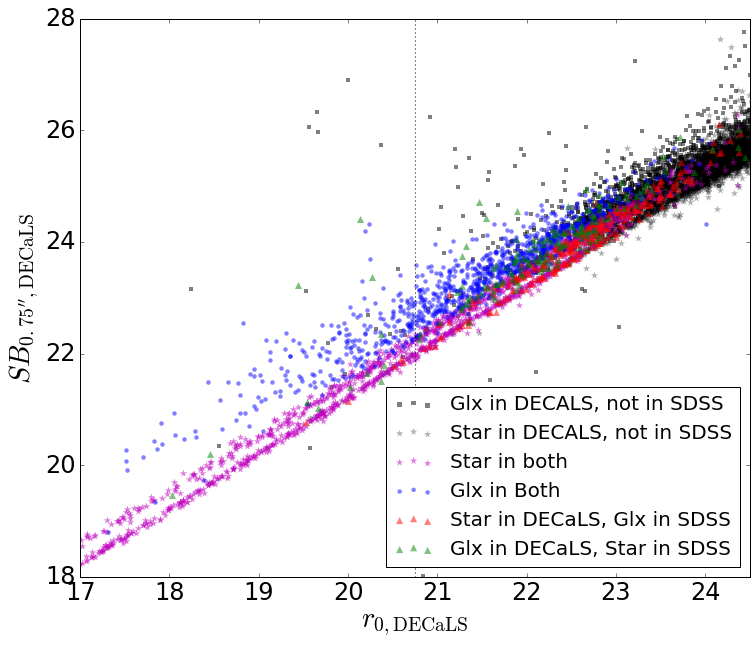

In [31]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sb_r_0.75'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
sstar = smatch['PHOT_SG']=='STAR'


dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar], (dnomatch[ynm] - dnoext)[~dnstar], 
            c='k', lw=0, alpha=.5, label='Glx in DECALS, not in SDSS', marker='s')
plt.scatter((dnomatch[xnm] - dnoext)[dnstar], (dnomatch[ynm] - dnoext)[dnstar], 
            c='k', lw=0, alpha=.3, s=60, 
            label='Star in DECALS, not in SDSS', marker='*')

plt.scatter(x[dstar&sstar], y[dstar&sstar], c='m', lw=0, alpha=.5, s=60,
            label='Star in both', marker='*')

plt.scatter(x[~dstar&~sstar], y[~dstar&~sstar], c='b', lw=0, alpha=.5, label='Glx in Both')
plt.scatter(x[dstar&~sstar], y[dstar&~sstar], c='r', lw=0, alpha=.5, 
            label='Star in DECaLS, Glx in SDSS', marker='^', s=50)
plt.scatter(x[~dstar&sstar], y[~dstar&sstar], c='g', lw=0, alpha=.5, 
            label='Glx in DECaLS, Star in SDSS', marker='^', s=50)



#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 28)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{0.75^{\prime \prime}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)

## 1.0" 

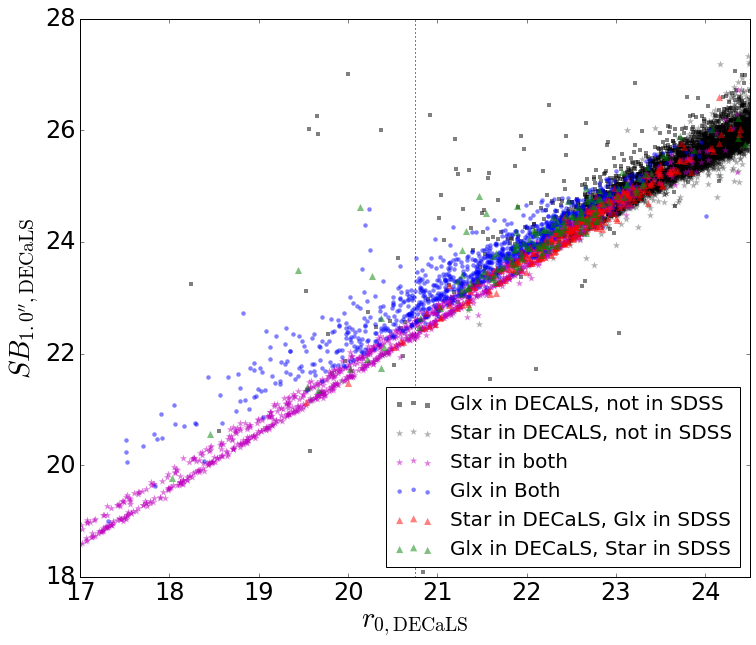

In [32]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sb_r_1'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
sstar = smatch['PHOT_SG']=='STAR'


dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar], (dnomatch[ynm] - dnoext)[~dnstar], 
            c='k', lw=0, alpha=.5, label='Glx in DECALS, not in SDSS', marker='s')
plt.scatter((dnomatch[xnm] - dnoext)[dnstar], (dnomatch[ynm] - dnoext)[dnstar], 
            c='k', lw=0, alpha=.3, s=60, 
            label='Star in DECALS, not in SDSS', marker='*')

plt.scatter(x[dstar&sstar], y[dstar&sstar], c='m', lw=0, alpha=.5, s=60,
            label='Star in both', marker='*')

plt.scatter(x[~dstar&~sstar], y[~dstar&~sstar], c='b', lw=0, alpha=.5, label='Glx in Both')
plt.scatter(x[dstar&~sstar], y[dstar&~sstar], c='r', lw=0, alpha=.5, 
            label='Star in DECaLS, Glx in SDSS', marker='^', s=50)
plt.scatter(x[~dstar&sstar], y[~dstar&sstar], c='g', lw=0, alpha=.5, 
            label='Glx in DECaLS, Star in SDSS', marker='^', s=50)


#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 28)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{1.0^{\prime \prime}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)

## 2.0" 

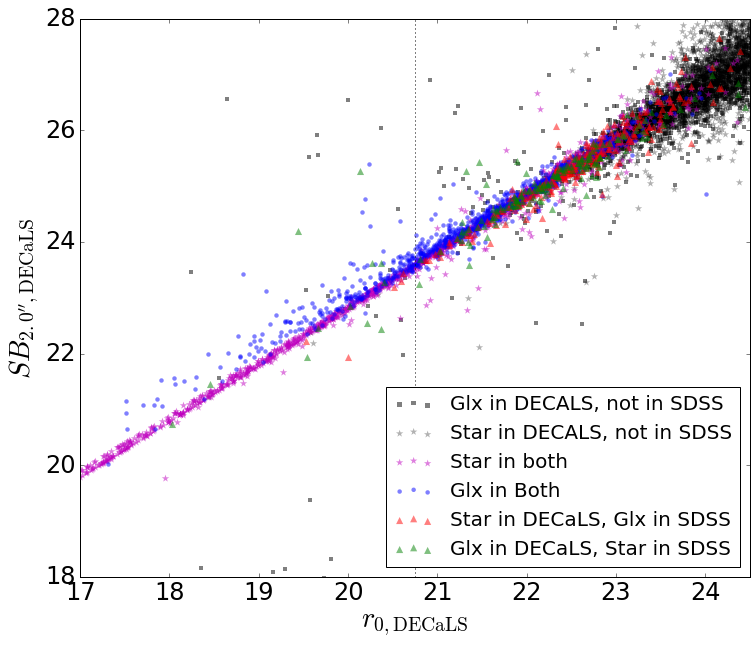

In [33]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sb_r_2'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
sstar = smatch['PHOT_SG']=='STAR'


dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar], (dnomatch[ynm] - dnoext)[~dnstar], 
            c='k', lw=0, alpha=.5, label='Glx in DECALS, not in SDSS', marker='s')
plt.scatter((dnomatch[xnm] - dnoext)[dnstar], (dnomatch[ynm] - dnoext)[dnstar], 
            c='k', lw=0, alpha=.3, s=60, 
            label='Star in DECALS, not in SDSS', marker='*')

plt.scatter(x[dstar&sstar], y[dstar&sstar], c='m', lw=0, alpha=.5, s=60,
            label='Star in both', marker='*')

plt.scatter(x[~dstar&~sstar], y[~dstar&~sstar], c='b', lw=0, alpha=.5, label='Glx in Both')
plt.scatter(x[dstar&~sstar], y[dstar&~sstar], c='r', lw=0, alpha=.5, 
            label='Star in DECaLS, Glx in SDSS', marker='^', s=50)
plt.scatter(x[~dstar&sstar], y[~dstar&sstar], c='g', lw=0, alpha=.5, 
            label='Glx in DECaLS, Star in SDSS', marker='^', s=50)


#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 28)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{2.0^{\prime \prime}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)

# Interpolated SDSS-like SB

Important thing to understand here: this is *not* the same as the SDSS SB's for a subtle reason.  The SDSS SB's are all from assuming an exponential profile.  Here, instead (because DECaLS doesn't have the data for exp profiles if the object is not found to be exp type), we use an SB within either the exponential half-light radius, the de Vaucouleurs effective radius, or the seeing FWHM for exp galaxies, DeV galaxies, or PSF's, respectively.

The flux is also not the *modeled* flux, but rather an interpolated flux at that radius from the apertures.

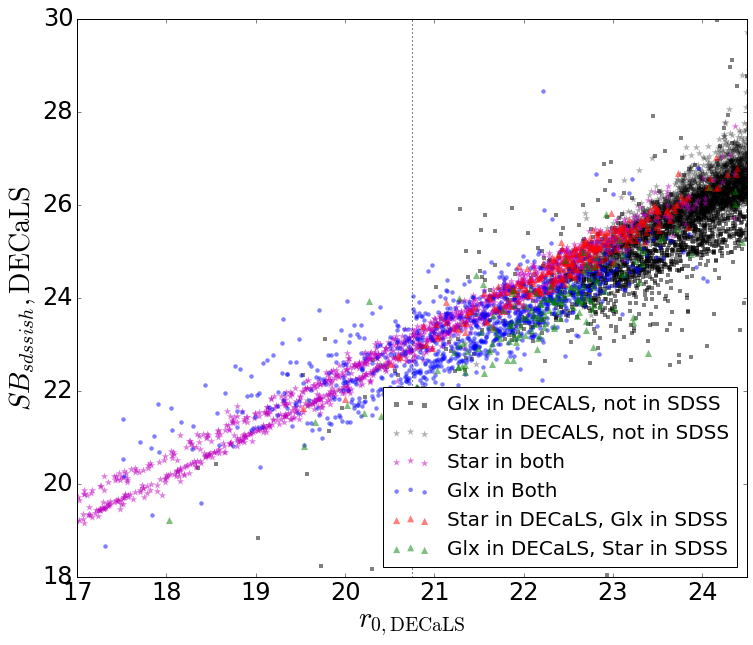

In [34]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sdss_like_sb_r'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
sstar = smatch['PHOT_SG']=='STAR'


dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar], (dnomatch[ynm] - dnoext)[~dnstar], 
            c='k', lw=0, alpha=.5, label='Glx in DECALS, not in SDSS', marker='s')
plt.scatter((dnomatch[xnm] - dnoext)[dnstar], (dnomatch[ynm] - dnoext)[dnstar], 
            c='k', lw=0, alpha=.3, s=60, 
            label='Star in DECALS, not in SDSS', marker='*')

plt.scatter(x[dstar&sstar], y[dstar&sstar], c='m', lw=0, alpha=.5, s=60,
            label='Star in both', marker='*')

plt.scatter(x[~dstar&~sstar], y[~dstar&~sstar], c='b', lw=0, alpha=.5, label='Glx in Both')
plt.scatter(x[dstar&~sstar], y[dstar&~sstar], c='r', lw=0, alpha=.5, 
            label='Star in DECaLS, Glx in SDSS', marker='^', s=50)
plt.scatter(x[~dstar&sstar], y[~dstar&sstar], c='g', lw=0, alpha=.5, 
            label='Glx in DECaLS, Star in SDSS', marker='^', s=50)




#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 30)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{sdssish}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)

The below plot is to see if there's significant differences between the two galaxy types, since their SB calculations are quite different

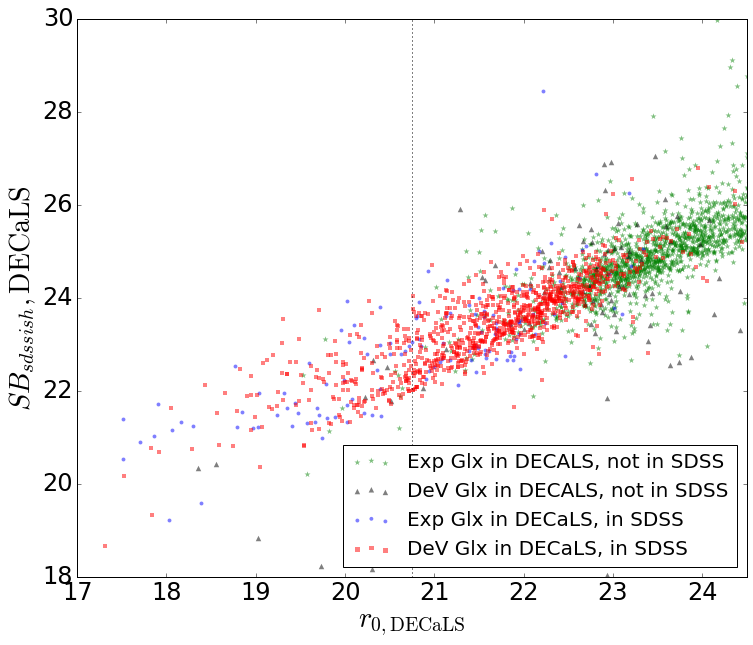

In [35]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sdss_like_sb_r'

dmextinction = -2.5*np.log10(dmatch['decam_mw_transmission'][:, 2])
x = dmatch[xnm] - dmextinction
y = dmatch[ynm] - dmextinction
dstar = dmatch['type']=='PSF '
ddev = dmatch['type']=='DEV '
sstar = smatch['PHOT_SG']=='STAR'


dnstar = dnomatch['type']=='PSF '
dndev = dnomatch['type']=='DEV '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])

plt.scatter((dnomatch[xnm] - dnoext)[~dnstar&~dndev], (dnomatch[ynm] - dnoext)[~dnstar&~dndev], 
            c='g', lw=0, alpha=.5, label='Exp Glx in DECALS, not in SDSS', marker='*', s=40)
plt.scatter((dnomatch[xnm] - dnoext)[~dnstar&dndev], (dnomatch[ynm] - dnoext)[~dnstar&dndev], 
            c='k', lw=0, alpha=.5, label='DeV Glx in DECALS, not in SDSS', marker='^', s=30)

plt.scatter(x[~dstar&ddev], y[~dstar&ddev], c='b', lw=0, alpha=.5, 
            label='Exp Glx in DECaLS, in SDSS', marker='o', s=15)
plt.scatter(x[~dstar&~ddev], y[~dstar&~ddev], c='r', lw=0, alpha=.5, 
            label='DeV Glx in DECaLS, in SDSS', marker='s', s=20)




#plt.hlines(24.5, 17, 21, colors='k', linestyles='--')
plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 24.5)
plt.ylim(18, 30)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{sdssish}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)

# Galaxy detection depth 

In [36]:
maggaldepth = -2.5*(np.log10(5*dmatch['decam_galdepth']**-0.5)-9)
maggaldepthr = maggaldepth[:, 2]

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


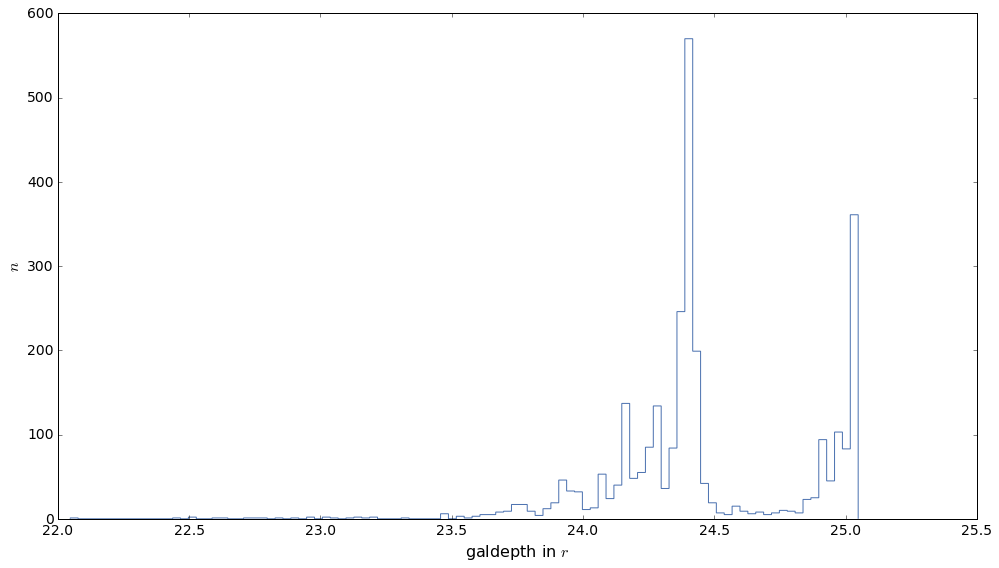

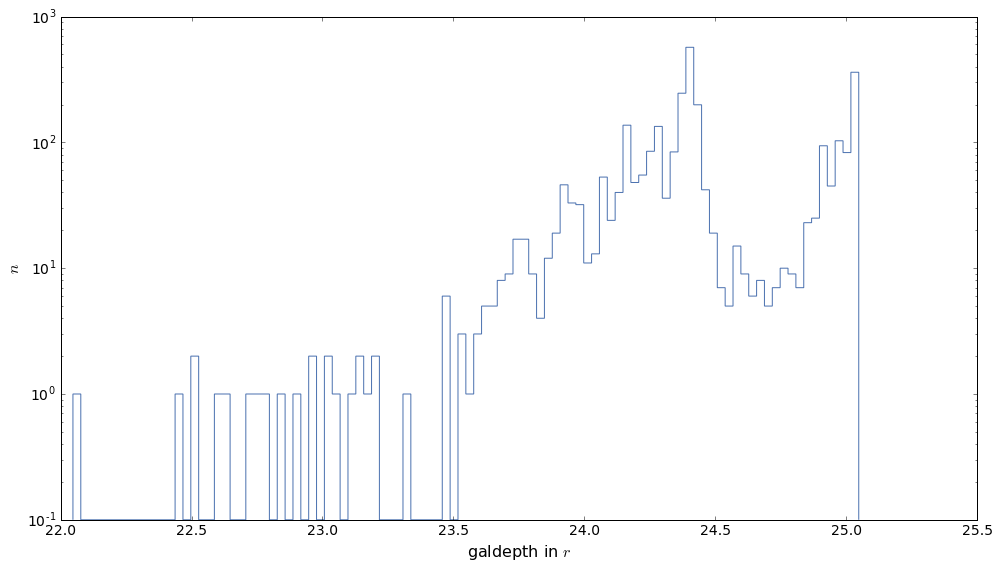

In [37]:
plt.figure()
plt.hist(maggaldepthr[np.isfinite(maggaldepthr)], bins=100, histtype='step', log=False)
plt.xlabel('galdepth in $r$')
plt.ylabel('$n$')
plt.tight_layout()

plt.figure()
plt.hist(maggaldepthr[np.isfinite(maggaldepthr)], bins=100, histtype='step', log=True)
plt.xlabel('galdepth in $r$')
plt.ylabel('$n$')
plt.tight_layout()

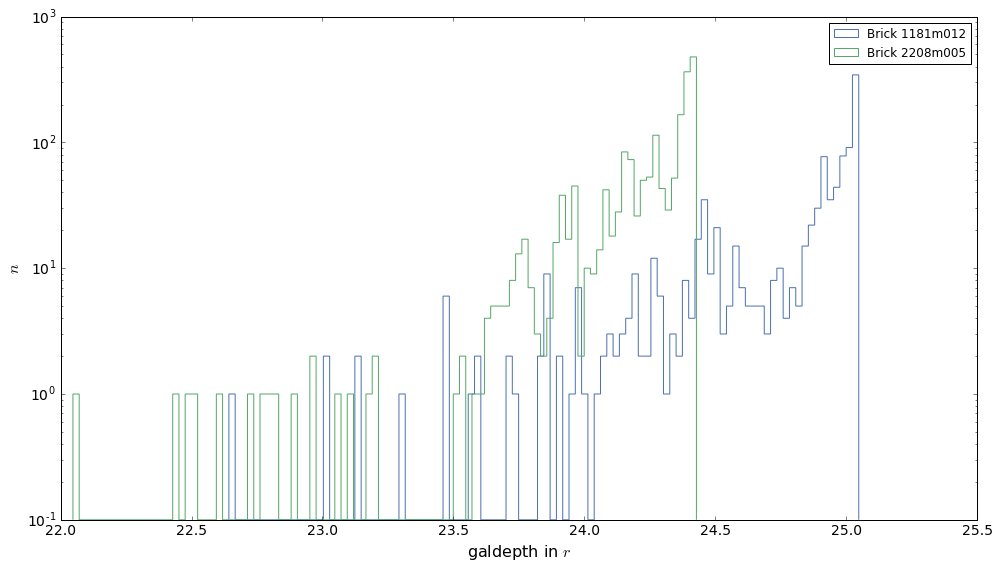

In [38]:
for bnm in np.unique(dmatch['brickname']):
    inbrick = dmatch['brickname'] == bnm
    plt.hist(maggaldepthr[np.isfinite(maggaldepthr)&inbrick], bins=100, histtype='step', log=True, label='Brick '+bnm)
   
plt.xlabel('galdepth in $r$')
plt.ylabel('$n$')
plt.legend(loc=0)
plt.tight_layout()